In [1]:
using Bloqade
using PythonCall
using KrylovKit
using SparseArrays
using Yao, YaoPlots
using Graphs
using Random
using GenericTensorNetworks
using Optim
using PythonCall
plt = pyimport("matplotlib.pyplot");

First, we specify the array of possible tower locations. Our example calculation will consider a 4x4 array.

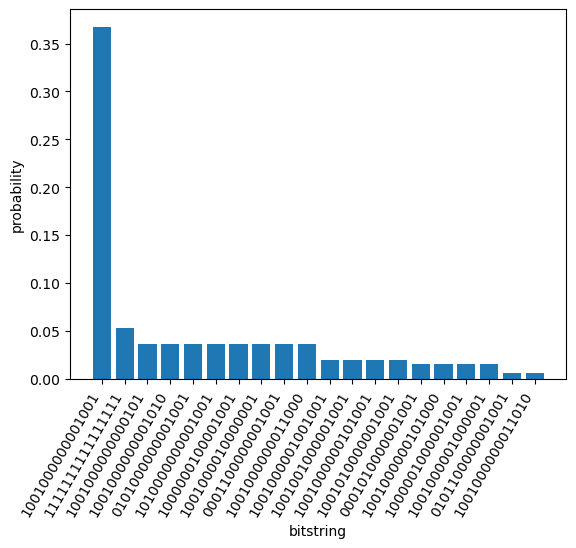

In [2]:
# specify 4x4 array
atoms = generate_sites(SquareLattice(), 4, 4; scale = 4.5);
Bloqade.plot(atoms, blockade_radius = 7.5);

# specify adiabatic protocol
T_max = 0.6
Ω_max = 2π * 4
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

# specify Hamiltonian and dynamics
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
reg = zero_state(nqubits(hamiltonian))
prob = SchrodingerProblem(reg, T_max, hamiltonian)
emulate!(prob)

bitstring_hist(prob.reg; nlargest = 20)

In [3]:
# determine MIS size classically
graph = BloqadeMIS.unit_disk_graph(atoms, 7.5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]
mis_size_and_counting[1]
mis_size = 4

4

In [4]:
# in order to get a set of bitstring solutions that we can manipulate, we make a large number of measurements,
# determine the unique set of measurements, and eliminate the bitstrings that do not have MIS length of 4
solutions = String[]

for i in 1:100
    m = Integer(measure(reg)[1])
    str = ""
    for i in 1:16
        str = str * string(m[i])
    end
    append!(solutions, [str])
end

# get unique solutions
unique!(solutions);

solutions_fixed = String[]
for i in 1:length(solutions)
    sum = 0
    for j in 1:16
        sum = sum + parse(Int, solutions[i][j])
    end
    if sum==4
        append!(solutions_fixed, [solutions[i]])
    end
end

number_of_solutions = length(solutions_fixed)

23

In [9]:
# randomly generate metric associated with each of the 16 sites
metrics = zeros(0)
for i in 1:16
    append!(metrics, rand())
end

# for each bitstring solution, multiply each bit by the corresonding metric
println("Bitstring        Rating")
for i in 1:length(solutions_fixed)
    print(solutions_fixed[i], " ")
    
    sum = 0
    for j in 1:16
        sum = sum + parse(Int, solutions_fixed[i][j])*metrics[j]
    end
    println(sum, "")
end

Bitstring        Rating
1001000000001001 1.5793766670083484
1010000000001010 2.0685979486952313
0001010000001001 1.619442778453172
0000010100001001 1.5929585440116867
1001000010000001 1.2956550003137908
1000001000001001 1.769332713399164
1010000000000101 1.929256872144633
1001000000001010 1.5257297961842728
0001010000011000 1.6627330914036365
1000000100001001 1.5528924325668636
1001000000000101 1.3863887196336746
0010100000001001 2.029389018020144
1000000110000001 1.269170765872306
1010000000001001 2.1222448195193073
1000001000001010 1.7156858425750885
1001000001000001 1.6216214939761544
0101000000011000 1.2971027486162772
1001000010000010 1.2420081294897152
1001000000011000 1.6226669799588131
0101000000000101 1.0608244882911384
0101000000001001 1.2538124356658127
0001100000001001 1.4865208655091857
0001100000011000 1.5298111784596502


We see that out of the solutions that do not have neighboring excitations, 1010000000001001 has the highest overall rating. This corresponds to cell towers positioned at sites 1, 3, 13, and 16. Next, we simulate a power-outage at a random site.

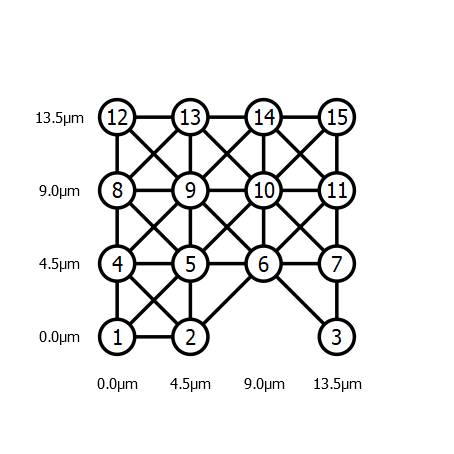

In [9]:
Random.seed!(7)
atoms = generate_sites(SquareLattice(), 4, 4; scale = 4.5) |> random_dropout(0.0625);
Bloqade.plot(atoms, blockade_radius = 7.5)
# code was run until randomly dropped site corresponded to one of the initial tower locations

Site 3 (according to the original labelling) has been removed from our array. We rerun our algorithm to determine the MIS.

In [11]:
# specify adiabatic protocol
T_max = 0.6
Ω_max = 2π * 4
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

# specify Hamiltonian and dynamics
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
reg = zero_state(nqubits(hamiltonian))
prob = SchrodingerProblem(reg, T_max, hamiltonian)
emulate!(prob)

# determine MIS size classically
graph = BloqadeMIS.unit_disk_graph(atoms, 7.5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]
mis_size_and_counting[1]
mis_size = 4

# in order to get a set of bitstring solutions that we can manipulate, we make a large number of measurements,
# determine the unique set of measurements, and eliminate the bitstrings that do not have MIS length of 4
solutions = String[]

for i in 1:100
    m = Integer(measure(reg)[1])
    str = ""
    for i in 1:15
        str = str * string(m[i])
    end
    append!(solutions, [str])
end

# get unique solutions
unique!(solutions);

solutions_fixed = String[]
for i in 1:length(solutions)
    sum = 0
    for j in 1:15
        sum = sum + parse(Int, solutions[i][j])
    end
    if sum==4
        append!(solutions_fixed, [solutions[i]])
    end
end

In [12]:
# randomly generate metric associated with each of the 15 sites
metrics = zeros(0)
for i in 1:15
    append!(metrics, rand())
end

# for each bitstring solution, multiply each bit by the corresonding metric
println("Bitstring        Metric")
for i in 1:length(solutions_fixed)
    print(solutions_fixed[i], " ")
    
    sum = 0
    for j in 1:15
        sum = sum + parse(Int, solutions_fixed[i][j])*metrics[j]
    end
    println(sum, "")
end

Bitstring        Metric
101000010100000 0.30166967414897516
101000000001001 1.0846040936329597
101000000001010 0.9652539393884894
101000010000001 0.686189123790324
101000010000010 0.5668389695458536
001100000001001 1.2986596072214058
100001000001001 1.2147138673459328
011000000001001 1.913642422713388
101000000011000 1.2462594991197984
011000010000001 1.5152274528707521
000101000001001 1.4287693809343789
101000000000101 1.5246675618655097
001100000011000 1.4603150127082445
011000000000101 2.353705890945938
001010000000101 1.9964571546425094
100001000001010 1.0953637131014622
000100100001001 2.0576323979675
001010000001001 1.5563936864099595


We see that out of the solutions that do not have neighboring excitations 000100100001001 has the highest overall rating. This corresponds to cell towers positioned at sites 4, 7, 12, and 15. Since site 3 was removed from our original array, these sites correpond to 5,8,13,16 on the original lattice. Combining the two solutions, we have determined that cell towers should be positioned at sites 1, 5, 8, 13, 16. 

Our solution has neighboring cell towers. Introducing redundancy into our network may result in direct neighbors. Of course, our basic calculations only simulated a single random power-outage. A more complete calculation would consider a larger array and numerous power-outage simulations- perhaps involving more than one site that goes down. That aside, our example illustrates a potential application that could be used in an industrial setting.